In [ ]:
!pip install pulp

     |████████████████████████████████| 40.6MB 106kB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.linalg import norm
from sympy.plotting import plot as spPlot
import matplotlib.pyplot as plt
import random as rd
from scipy.sparse import *
from scipy.sparse.linalg import *
from google.colab import drive
from scipy.optimize import linprog
from pulp import LpMaximize, LpProblem, LpStatus, lpSum, LpVariable
drive.mount('/content/drive')


Mounted at /content/drive


# Taller 2

# Nicolás Betancourt

# Optimización estocástica

# Introducción al problema

## Acciones, estados y recompensas

Un objeto volador retrasado por los azares del viento y del clima quiere volver a su hogar con ayuda de las matemáticas. Esto sin olvidar que en su trayecto hay peligros y que en casa lo requieren en el menor tiempo posible. Dicho de otra forma: 

Sea $[M]=\{M,M+1,\cdots,200\}$ y  $L:=[M]\times [M]$  la retícula $(200-M)\times (200-M)$ con esquina en $(M,M)$ y $F\subseteq R$ un conjunto de puntos prohibidos tal que $ \frac{|F|}{|R|}=0.05$ y $D := [155,157]\times [155,157]$ el conjunto de destino. Con esto definimos un proceso de decisión de Markov descontado de horizonte infinito como sigue


1.  $T=\{0,1,\cdots\}, $ $S:=R$
2. $$\mathcal{A}((x,y)):=\begin{cases}\{u,d,l,r\} & x\neq M,0 \; y\neq M,0   \\
\{u,l,r\} &  x\neq M,0 \; y=0 \\  \{u,d,l\} &  x= M \; y=0,M \\
\{d,l,r\} &  x\neq M,0 \; y=0 \\  \{u,d,l\} &  x\neq M,0 \; y=M \\ \{u,l,r\} &  x=0,\; y\neq 0,M \\  \{u,d,l\} &  x= M, \; y\neq0,M \\\end{cases} $$ 

3. $$r(S_{t},a, S_{t+1})=\begin{cases} - \lVert S_{t+1}-D \rVert^2 & S_t,S_{t+1} \notin F \\ -2(200-M)^2-1 & S_t \in F\; o\; S_{t+1} \in F  \end{cases} $$

Donde $ \lVert S_{t+1}-D \rVert^2:=\underset{S\in D}\min \lVert S_{t+1}-S \rVert^2$. 


También vamos a establecer que $r(S_t,a,S_{t+1})=-2(200-M)^2-1$ si tomar la acción $a$ en el estado $S_t$ hace que la probabilidad de salir de la retíícula sea positiva.

La magitud $\lVert S_{t+1}-D \rVert^2 $ se puede calcular explícitamente al observar que  es la distancia de $ S_{t+1}$ a un producto cartesiano. Esta puede calcularse analizando distintos sectores del plano y dándole ($x,y<155, $ o $x>157,  y<157 $) un valor explícito, lo cual da lugar a la siguiente fórmula

$$ \underset{S\in D}\min \lVert (x,y)-S \rVert =$$

 $$ (1-\mathbb{1}_D(x,y) )\left[  (155-x)^2\mathbb{1}_{x\leq 155}(x) +(157-x)^2\mathbb{1}_{x\geq 157}(x) + (155-y)^2\mathbb{1}_{y\leq 155}(y)+ (157-y)^2 \mathbb{1}_{y\geq 157}(y) \right] $$

4. Las probabilidades de transición son las especificadas en el enunciado de la tarea definidas razonablemente en los bordes, esto es, si se está en un punto $(x,y)$  y se toma una decisión $a$ tal que la probabilidad de salir de la rejilla es positiva, entonces $Q((x,y) | (x,y),a)=1$.


En este taller la idea es que $ M$ sea 0, pero para pruebas lo podremos elegir más grande pero siempre exigiendo que  $M<130$. $F$ lo vamos a elegir como una unión de 5 cuadrados disjuntos y cercanos a $D$. Cada uno de ellos medirá 1% del área total de $L$.



## Orden en los estados

Para poder ver las reglas de decisión como vectores necesitamos enumerar los estados. Eso lo haremos de la siguiente forma:
Al estado $(x,y) \in L$ le vamos a asignar el índice 

$$ (x-M)+ (y-M)(200-M) $$
Esto significa que vamos a enumerar los nodos de izquerda a derecha de arriba a abajo. Además, al índice $i$ le corresponde el punto
$$ (x_i,y_i):=\left( r+M, \frac{i-r}{200-M}+M \right)$$
 donde $r:=\operatorname{Res}(i,200-M)$



Esto implica, que si tengo un punto $(x,y) \in L$ de índice $i$ su vecinos horizontales y vertícales tienen los siguientes índices. 


* $(x+1,y)$ tiene índice $i+1$.
* $(x-1,y)$ tiene índice $i-1$.
* $(x-2,y)$ tiene índice $i-2$.
* $(x,y+1)$ tiene índice $i+200-M$.
* $(x,y+2)$ tiene índice $i+2(200-M)$.
* $(x-1,y+1)$ tiene índice $i+200-M-1$.
* $(x-1,y+2)$ tiene índice $i+2(200-M)-1$.
* $(x-2,y+1)$ tiene índice $i+200-M-2$.
* $(x+1,y+1)$ tiene índice $i+200-M+1$
* $(x,y-1)$ tiene índice $i-(200-M)$
* $(x-1,y-1)$ tiene índice $i-1-(200-M)$

Esto va ayudar a la programación del código que genera la matriz sparse $P_d$
para una regla de decisión Markoviana determinísitca dada, pues esta matriz va a tener a lo más 4 entradas no nulas por fila. Más específicamente

* Si $d(i)=u$ entonces solo las entradas $i+1, i+2, i+2(200-M)-1, i+200-M-1$ de la fila $i$ de $P_d$ van a ser no nulas. Y van a ser $0.3,0.4,0.2,0.1 $ respectivamente. 
* Si $d(i)=d$ entonces solo las entradas $i, i-(200-M), i-1,i-1-(200-M)$ de la fila $i$ de $P_d$ van a ser no nulas. Y van a ser $0.3,0.3,0.2,0.2$ respectivamente. 
* Si $d(i)=l$ entonces solo las entradas $i+200-M-1, i-1, i-2,i+200-M-2$ de la fila $i$ de $P_d$ van a ser no nulas. Y van a ser $0.3,0.2,0.3,0.2$ respectivamente. 
* Si $d(i)=r$ entonces solo las entradas $i+1, i+200-M+1, i,i+200-M$ de la fila $i$ de $P_d$ van a ser no nulas. Y van a ser $0.3,0.4,0.2,0.1$ respectivamente.


Todo lo anterior es salvo que $i$ se encuentre en un borde, en cuyo caso casi todas las entradas seríían cero salvo la $i$ que sería 1. Para identificar índices en el borde, denote $i//m:= \frac{i-\operatorname{Res}(i,m)}{m}$ y note que

* i está en el borde inferior si y solo si $i//(200-M)=0$.
* i está en el borde de más a la derecha si y solo si $\operatorname{Res}(i,200-M)=-1$.
* i está en el borde de arriba si y solo si $i//(200-M)=200-M-1$
* i está en el borde de más a la izquierda si y solo si $\operatorname{Res}(i,200-M)=-1$.


# Código y detalles de implementación

Funciones y variables globales que se usan a lo largo de todo el taller

In [ ]:
M=0
#Enumeramos los nodos en la retícula y el destino D usando aritmética modular
L=[ (a%(200-M)+M,a//(200-M)+M) for a in range((200-M)**2)]
D=[ (a%3+155,a//3+157) for a in range(3**2)]
#Elegimos la zona prohibida
tamaño=int(np.sqrt(((200-M)**2)*0.01))
esquina1_x=130
esquina1_y=130
esquina2_x=165
esquina2_y=165
esquina3_x=130
esquina3_y=160
esquina4_x=160
esquina4_y=130

F1=[ (a%tamaño+esquina1_x,a//tamaño+esquina1_y) for a in range(int(((200-M)**2)*0.01))]
F2=[ (a%tamaño+esquina2_x,a//tamaño+esquina2_y) for a in range(int(((200-M)**2)*0.01))]

F3=[ (a%tamaño+esquina3_x,a//tamaño+esquina3_y) for a in range(int(((200-M)**2)*0.01))]
F4=[ (a%tamaño+esquina4_x,a//tamaño+esquina4_y) for a in range(int(((200-M)**2)*0.01))]
F5=[ (a%tamaño+105,a//tamaño+140) for a in range(int(((200-M)**2)*0.01))]

F=F1+F2+F3+F4+F5

In [ ]:
#En repetidas ocasiones vamos a necesitar los indices de los puntos de la rejilla que están en los bordes, en D, en F así que los precalcularemos
idx=np.array(range((200-M)**2))
idx_d=list(range(200-M))+list(np.arange(200-M)*(200-M))
idx_r=list((200-M)*np.arange(1,200-M+1)-1)+list((200-M)*(200-M-1)+np.arange(200-M))
idx_u=list((200-M)*(200-M-1)+np.arange(200-M))+list((200-M)*(200-M-2)+np.arange(200-M))+list(np.arange(200-M)*(200-M))
idx_l=list((200-M)*np.arange(200-M))+list((200-M)*np.arange(200-M)+1)+list((200-M)*(200-M-1)+np.arange(200-M))
idx_bordes=idx_l+idx_u+idx_r+idx_d
idx_D=[int(pto[0]-M+ (pto[1]-M)*(200-M)) for pto in D] 
idx_F=[int((pto[0]-M)+ (pto[1]-M)*(200-M)) for pto in F] 
idx_normales=list( set(idx).difference(set(idx_D+idx_F)) )

In [ ]:
def indices(a,i):
  if a=='u':
    return np.array([i+200-M,i+2*(200-M),i+2*(200-M)-1,i+200-M-1])
  if a=='d':
    return np.array([i, i-(200-M), i-1,i-1-(200-M)])
  if a=='l':
    return np.array([i+200-M-1, i-1, i-2,i+200-M-2])
  if a=='r':
    return np.array([i+1, i+200-M+1, i,i+200-M])
def probas(a):
  if a=='u':
    return [0.3,0.4,0.2,0.1]
  if a=='d':
    return [0.3,0.3,0.2,0.2]
  if a=='l':
    return [0.3,0.2,0.3,0.2]
  if a=='r':
    return [0.3,0.4,0.2,0.1]

def P(d):
  #Indices donde la política es u,d,l,r respectivamente pero fuera de los bordes
  u_indices=list(set(idx[d=='u']).difference(set(idx_u)))
  d_indices=list(set(idx[d=='d']).difference(set(idx_d)))
  l_indices=list(set(idx[d=='l']).difference(set(idx_l)))
  r_indices=list(set(idx[d=='r']).difference(set(idx_r)))
  #Lugares donde la fila va a ser todo  ceros salvo un 1 en la diagonal
  u_ones=list(set(idx[d=='u']).intersection(set(idx_u)))
  d_ones=list(set(idx[d=='d']).intersection(set(idx_d)))
  l_ones=list(set(idx[d=='l']).intersection(set(idx_l)))
  r_ones=list(set(idx[d=='r']).intersection(set(idx_r)))
  
  #indices de las filas y columnas que no van a ser cero
  rowIndices=list(np.repeat(u_indices,4))+list(np.repeat(d_indices,4))+ list(np.repeat(l_indices,4))+ list(np.repeat(r_indices,4))+u_ones+d_ones+l_ones+r_ones
  #np.hstack([np.repeat(u_indices,4),np.repeat(d_indices,4),np.repeat(l_indices,4), np.repeat(r_indices,4), u_ones, d_ones, l_ones ,r_ones ]).reshape(-1,1)
  colIndices=indices('u', np.array(u_indices)).T.reshape(-1,).tolist()+indices('d', np.array(d_indices)).T.reshape(-1,).tolist()+indices('l', np.array(l_indices)).T.reshape(-1,).tolist()+indices('r', np.array(r_indices)).T.reshape(-1,).tolist()+u_ones+d_ones+l_ones+r_ones
  #indices('u',np.array(u_indices)).reshape(1,-1).tolist()[0]+indices('d',np.array(d_indices)).reshape(1,-1).tolist()[0]+indices('l',np.array(l_indices)).reshape(1,-1).tolist()[0]+indices('r',np.array(r_indices)).reshape(1,-1).tolist()[0]+u_ones+d_ones+l_ones+r_ones
  #np.vstack([indices('u', np.array(u_indices))+ indices('d', d_indices).reshape(-1,1), indices('l', l_indices).reshape(-1,1), indices('r', r_indices).reshape(-1,1), u_ones, d_ones, l_ones ,r_ones]).reshape(-1,1)
  #Valores que van a ir en las entradas no nulas
  valores=len(u_indices)*probas('u')+len(d_indices)*probas('d')+len(l_indices)*probas('l')+len(r_indices)*probas('r')+[1]*(len(u_ones)+len(d_ones)+len(l_ones)+len(r_ones))  
  #np.vstack([probas('u', u_indices).reshape(-1,1), probas('d', d_indices).reshape(-1,1), probas('l', l_indices).reshape(-1,1), probas('r', r_indices).reshape(-1,1)]).reshape(-1,1)
  
 
  

  return csr_matrix((valores, (rowIndices, colIndices)), shape=((200-M)**2, (200-M)**2))


def dist(i):
  i=i.reshape(-1,1)
  if i.shape[0]!=0:
    
    x=i%(200-M) +M 
    y=i//(200-M) +M
    distancias= -(1-np.isin(i,idx_D))*(((155-x)**2)*(x<=155)+((157-x)**2)*(x>=157)+((155-y)**2)*(y<=155)+((157-y)**2)*(y>=157))
    return distancias
  else: 
    return np.array([])  

def r(i,a):
  fila=dist(indices(a,i).T.reshape(-1,1)).reshape(1,-1)
  
  qq=np.matmul(fila.reshape(-1,4),np.array(probas(a)).reshape(4,1))
  return qq
  


def rec_d(d):
  retornable=np.zeros((200-M)**2)
  #Indices donde la política es u,d,l,r respectivamente pero fuera de los bordes
  u_indices=idx[d=='u'].tolist()
  d_indices=idx[d=='d'].tolist()
  l_indices=idx[d=='l'].tolist()
  r_indices=idx[d=='r'].tolist()
  retornable[u_indices]=r(np.array(u_indices), 'u').reshape(-1,)
  retornable[d_indices]=r(np.array(d_indices), 'd').reshape(-1,)
  retornable[l_indices]=r(np.array(l_indices), 'l').reshape(-1,)
  retornable[r_indices]=r(np.array(r_indices), 'r').reshape(-1,)
  #Penalizar ir a los bordes
  retornable[list(set(u_indices).intersection(set(idx_u)))]=-2*(200-M)**2-1
  retornable[list(set(d_indices).intersection(set(idx_d)))]=-2*(200-M)**2-1
  retornable[list(set(l_indices).intersection(set(idx_l)))]=-2*(200-M)**2-1
  retornable[list(set(r_indices).intersection(set(idx_r)))]=-2*(200-M)**2-1
  retornable[idx_F]=-2*(200-M)**2-1
  retornable[idx_D ]=2*(200-M)**2
  
  
  return retornable


  


In [ ]:
def GraficarRetícula(ax,imprimir=True):
  if imprimir:
    print('Los puntos prohibidos alcanzan un ', int(100*(len(F)/len(L))), '% del total del área de la retícula')
  dotSize=200/(10*M+1)
  if M==0:
    dotSize=0.05
  ax.scatter([p[0] for p in L],[p[1] for p in L],s=dotSize,c='blue')
  #Graficamos la región de destino
  ax.scatter([p[0] for p in D],[p[1] for p in D],c='green')
  #Graficamos los puntos prohibidos
  ax.scatter([p[0] for p in F],[p[1] for p in F],c='red')
  ax.legend(['rejilla', 'D', 'F'])
  ax.set_title('Gráfica de la retícula y la región que se quiere evitar')

## Gráfica de la retícula y la región que se quiere evitar

Los puntos prohibidos alcanzan un  5 % del total del área de la retícula


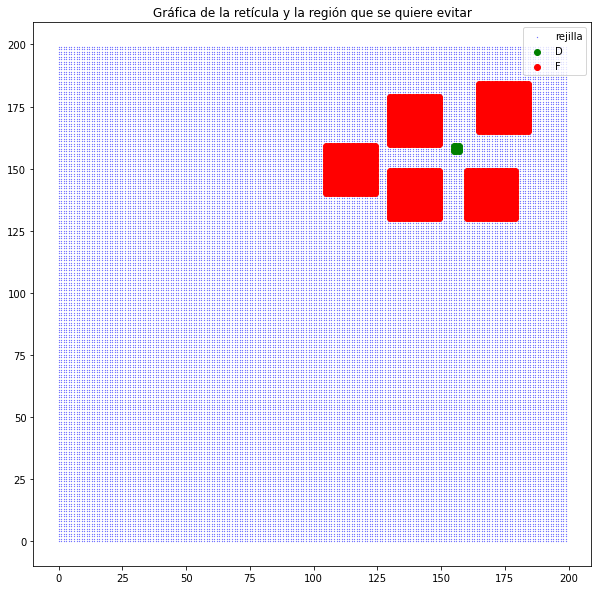

In [ ]:
#Se grafica la rejilla
fig, ax = plt.subplots(figsize=(10,10))
GraficarRetícula(ax)

Mapas de calor que indican la magnitud de la recompensa resultante por tomar determinada accióón en cada punto de la retícula

Text(0.5, 1.0, 'Recompensa esperada de tomar la decisión u en cada nodo')

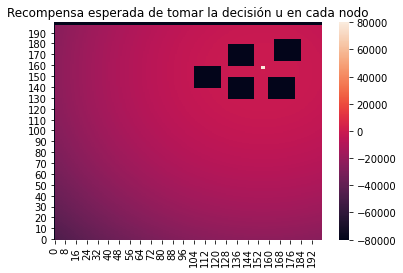

In [ ]:
import seaborn as sns
a='u'
ax = sns.heatmap(rec_d(np.array([a]*(200-M)**2)).reshape((200-M,200-M)), vmin=-2*(200-M)**2-1, vmax=2*(200-M)**2)
ax.invert_yaxis()
ax.set_title('Recompensa esperada de tomar la decisión '+a+' en cada nodo')

Text(0.5, 1.0, 'Recompensa esperada de tomar la decisión d en cada nodo')

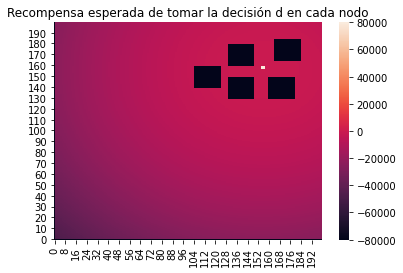

In [ ]:
import seaborn as sns
a='d'
ax = sns.heatmap(rec_d(np.array([a]*(200-M)**2)).reshape((200-M,200-M)), vmin=-2*(200-M)**2-1,  vmax=2*(200-M)**2)
ax.invert_yaxis()
ax.set_title('Recompensa esperada de tomar la decisión '+a+' en cada nodo')

Text(0.5, 1.0, 'Recompensa esperada de tomar la decisión l en cada nodo')

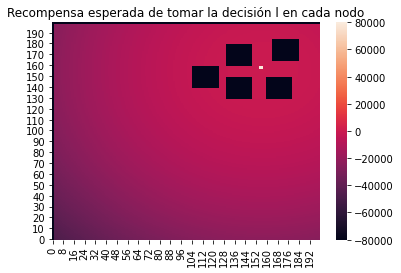

In [ ]:
import seaborn as sns
a='l'
ax = sns.heatmap(rec_d(np.array([a]*(200-M)**2)).reshape((200-M,200-M)), vmin=-2*(200-M)**2-1,  vmax=2*(200-M)**2)
ax.invert_yaxis()
ax.set_title('Recompensa esperada de tomar la decisión '+a+' en cada nodo')

Text(0.5, 1.0, 'Recompensa esperada de tomar la decisión r en cada nodo')

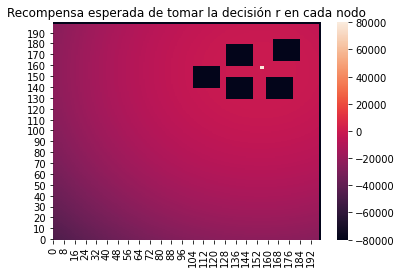

In [ ]:
import seaborn as sns
a='r'
ax = sns.heatmap(rec_d(np.array([a]*(200-M)**2)).reshape((200-M,200-M)), vmin=-2*(200-M)**2-1,  vmax=2*(200-M)**2)
ax.invert_yaxis()
ax.set_title('Recompensa esperada de tomar la decisión '+a+' en cada nodo')

## Iteración por política

Una vez tengamos el $v$ que surge de resolver el sistema $(I-\lambda P_d)v=r_d$, debemos construir la siguiente política $ d_{n+1}$ bajo la regla 
$$ d_{n+1}(s) \in \underset{a  \in \mathcal{A}}{argmax} \left\{ r(s,a)+\lambda \sum_{j} p(j|s,a)v(j) \right\} $$

Si denotamos por $P_a$ la matriz de transición de la regla de decisión que toma siempre la acción $a$, lo anterior se convierte en 
 
$$ d_{n+1} \in \underset{a  \in \mathcal{A}}{argmax} \left\{ r+\lambda \left(P_u v | P_d v | P_l v | P_r v\right)  \right\} $$

lo anterior es lo que imitaremos a continuación

Se precalculan cosas que  se van a ser constantes en  varias iteraciones

In [ ]:
# Vector de recompensas de la forma  r(0,u), r(1,u), r(2,u)...r(ultimo nodo, u)
recompensasU=r(idx,'u').reshape((-1,1))
# Vector de recompensas de la forma  r(0,d), r(1,d), r(2,d)...r(ultimo nodo, d)
recompensasD=r(idx,'d').reshape((-1,1))
# Vector de recompensas de la forma  r(0,l), r(1,l), r(2,l)...r(ultimo nodo, l)
recompensasL=r(idx,'l').reshape((-1,1))
# Vector de recompensas de la forma  r(0,r), r(1,r), r(2,r)...r(ultimo nodo, r)
recompensasR=r(idx,'r').reshape((-1,1))
#Matriz de recompensas por estado con filas u,d,l,r
# la columna s de esta matriz es r(s,u), r(s,d), r(s,l), r(s,r)
recompensasEstados=np.array([recompensasU, recompensasD, recompensasL, recompensasR]).reshape(4,(200-M)**2)


acciones={0:'u',1:'d', 2:'l', 3:'r'}
accionesInv={'u':0,'d':1,'l':1,'r':3}
lmbda=0.9

In [ ]:
Pr_u=P( np.array(['u']*(200-M)**2).reshape((200-M)**2,) )
Pr_d=P( np.array(['d']*(200-M)**2).reshape((200-M)**2,) )
Pr_l=P( np.array(['l']*(200-M)**2).reshape((200-M)**2,) )
Pr_r=P( np.array(['r']*(200-M)**2).reshape((200-M)**2,) )

Se inicializa $d$ al azar y se resuelve el sistema lineal 

Se define $d_{n+1}$

In [ ]:


try:
  d=pd.read_csv('/content/drive/MyDrive/OEstocastica/vNext_'+str(M)+'.csv', index_col='Unnamed: 0').values.reshape(-1,)
  print('si lo leyó')
except:
  d=np.random.choice(['u','d','l','r'], size=(200-M)**2, replace=True)
  print('pichis')



si lo leyó


In [ ]:
dNext=np.zeros((200-M)**2,)
cont=0
parar=False
while not parar and cont<100:
  P_d=P(d)
  r_d=rec_d(d)
  #csr_matrix(rec_d(d)).reshape(-1,1)
  matriz=identity((200-M)**2)-lmbda*P_d
  v=bicg(matriz,r_d)[0]
  cont+=1
  columnas=[ Pr_u.dot(v), Pr_d.dot(v), Pr_l.dot(v), Pr_r.dot(v) ]
  vector=recompensasEstados.T + lmbda*np.array(columnas).T
  nuevo_d=np.argmax(vector,axis=1).tolist()
  dNext=np.array(list(map(acciones.get, nuevo_d)))
  if np.all(np.max(vector,axis=1)==vector[np.arange((200-M)**2),list(map(accionesInv.get, d.tolist()))]):
    print('AAAAAAAAAAAAAAAAAAAAAAAAAA')
    parar=True
  d=dNext
  


In [ ]:
try:
  pd.DataFrame(dNext).to_csv('/content/drive/MyDrive/OEstocastica/vNext_'+str(M)+'.csv')
except:
  print('Monte su drive para que funcione todo muy bien')

In [ ]:
prohibido={'u':idx_u,'d':idx_d,'l':idx_l,'r':idx_r}


def roll(massDist):
    randRoll = rd.random() # in [0,1]
    sum = 0
    result = 0
    for mass in massDist:
        sum += mass
        if randRoll < sum:
            return result
        result+=1



def simulacion(d,start):
  lista=[start]
  aleatorio=roll(probas(d[start]))
  
  iNext=list(indices(d[start],start))[aleatorio]
  while (iNext not in idx_D) and (iNext not in prohibido[d[iNext]]):
    lista.append(iNext)
    indxs=indices(d[iNext],iNext)
    prbs=probas(d[iNext])
    iNext=list(indxs)[roll(prbs)]
  return lista

### Resultados numéricos: un ejemplo

Los puntos prohibidos alcanzan un  5 % del total del área de la retícula


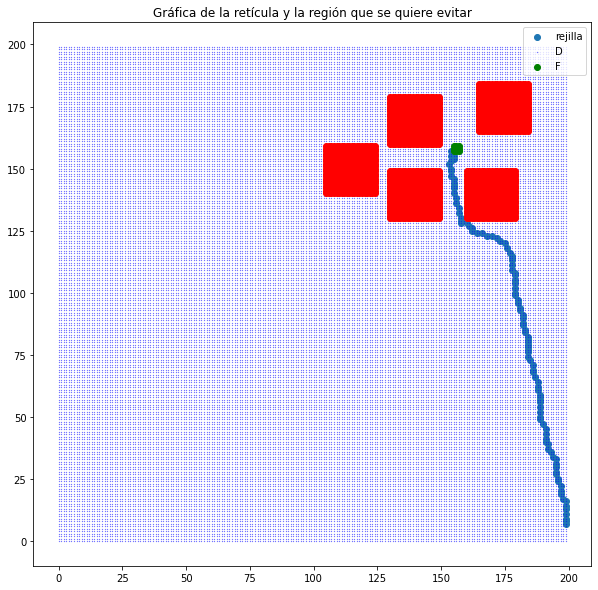

In [ ]:
graficar=simulacion(dNext,1599)
fig, ax = plt.subplots(figsize=(10,10))

x=[i%(200-M)+M for i in graficar]
y=[i//(200-M)+M for i in graficar]
ax.scatter(x,y)
GraficarRetícula(ax)

### Simulación con dos puntos iniciales distintos

Vamos a graficar 100 trayectorias con la políítica anterior y viendo en cada una cuánto fue el número de pasos necesarios para llegar al destino. Esto lo vamos a registrar en una gráfica y lo vamos a hacer para 2 puntos iniciales distintos

Trayectorias que vamos a simular

Los puntos prohibidos alcanzan un  5 % del total del área de la retícula


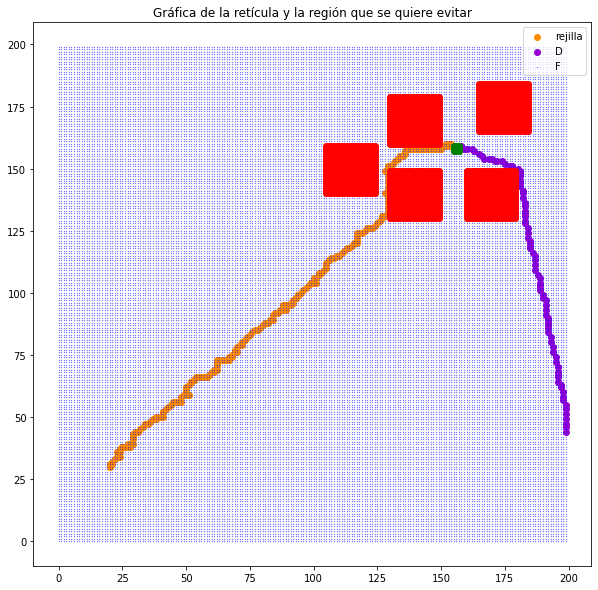

In [ ]:
#Primer punto inicial
graficar6k=simulacion(dNext,6020)
fig, axx = plt.subplots(figsize=(10,10))
x6k=[i%(200-M)+M for i in graficar6k]
y6k=[i//(200-M)+M for i in graficar6k]
#segundo punto inicial
graficar8k=simulacion(dNext,8999)
x8k=[i%(200-M)+M for i in graficar8k]
y8k=[i//(200-M)+M for i in graficar8k]

axx.scatter(x6k,y6k,c='darkorange')
axx.scatter(x8k,y8k,c='darkviolet')
GraficarRetícula(axx)

In [ ]:
dictSimulacion={6020:[],8999:[]}
for simular in range(100):
  dictSimulacion[6020].append(len(simulacion(dNext,6020)))
  dictSimulacion[8999].append(len(simulacion(dNext,8999)))


Varianza con punto de partida=(20,30) 44.84900333340754
Varianza con punto de partida=(199,44) 3.6685010562898848


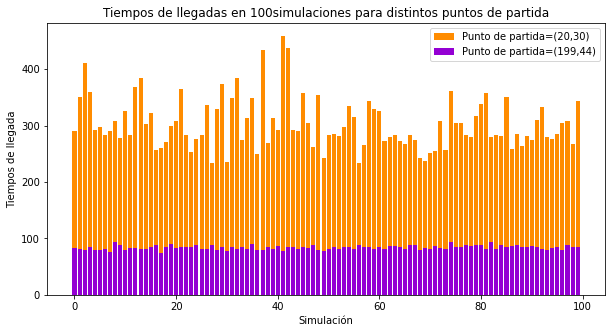

In [ ]:
fig, axSim = plt.subplots(figsize=(10,5))
axSim.bar(range(100),dictSimulacion[6020],color='darkorange')
axSim.bar(range(100),dictSimulacion[8999],color='darkviolet')
axSim.set_title('Tiempos de llegadas en 100simulaciones para distintos puntos de partida')
axSim.set_xlabel('Simulación')
axSim.set_ylabel('Tiempos de llegada')
print('Varianza con punto de partida=('+str(6020%(200-M)+M)+','+str(6020//(200-M)+M)+')', np.std(dictSimulacion[6020]) )
print('Varianza con punto de partida=('+str(8999%(200-M)+M)+','+str(8999//(200-M)+M)+')', np.std(dictSimulacion[8999]) )


axSim.legend(['Punto de partida=('+str(6020%(200-M)+M)+','+str(6020//(200-M)+M)+')','Punto de partida=('+str(8999%(200-M)+M)+','+str(8999//(200-M)+M)+')'])

## Programación Lineal

Sea $A_1 \in \mathbb{R}^{(200-M)^2 \times 4(200-M)^2}$ la matriz cuya fila $j$ es 
$$ \left( p(j|0,u), p(j|0,d), p(j|0,l),  p(j|0,r),\cdots,  p(j|(200-M)^2-1,l),  p(j|(200-M)^2-1,r)\right)  $$
y $A_2 \in \mathbb{R}^{(200-M)^2 \times 4(200-M)^2}$ la matriz que es cero en todas partes, salvo en las diagonales 0,1,2,3, en donde es exactamente 1 i.e. 

$(A_2)_{ij} \neq 0 \leftrightarrow  i-j \leq 3 $

Con esta notación, el programa lineal a resolver es

$$  \begin{array} &\operatorname{max} & r^T x \\ \text{s.a.} & (A_2-\lambda A_1)x=\alpha \\ &x\geq 0 \end{array} $$
 donde $r\in \mathbb{R}^{4(200-M)^2}$ está dado por 

$$ \begin{pmatrix} r(0,u) \\ r(0,d) \\ r(0,l) \\ r(0,r) \\ \vdots \\ r((200-M)^2-1,l) \\  r((200-M)^2-1,r) \end{pmatrix}$$

y $\alpha$ es cualquier distribución inicial. 



In [ ]:
#Vamos a utilizar la distribución inicial uniforme
alpha=(1/(200-M)**2)*np.ones(((200-M)**2,1))
#Máás adelante veremos que se pudo haber escogido cualquier alpha

In [ ]:
# Creamos el solver que maximiza
model = LpProblem(sense=LpMaximize)
equis={}
#Defino el vector x entrada por entrada x(j,a), especificando que es positivo
for a in ['u','d','l','r']:
    for j in range((200-M)**2):
        equis[(j,a)]= LpVariable(name='x('+str(j)+','+a+')', lowBound=0)
        
        


In [ ]:
#En este solver uno añade cada sumando
# de la función objetivo (o las restricciones)
# a una lista, y las suma
listaObjective=[]

#Función objetivo
for a in ['u','d','l','r']:
    for j in range((200-M)**2):
      listaObjective.append(equis[(j,a)]*float(recompensasEstados[ accionesInv[a]][j]))


        

In [ ]:
#Se añade la funcióón objetivo
model+=lpSum(listaObjective)

In [ ]:
Pr_ = {'u':Pr_u,'d':Pr_d,'l':Pr_l,'r':Pr_r}

    



In [ ]:
eses_u=list(Pr_['u'][:,895].nonzero()[0])
probas_u=[ Pr_u[fila,895] for fila in eses_u]

In [ ]:
probas_u

[0.4, 0.2, 0.3, 0.1]

In [ ]:
#Las restricciones se hacen igual
for j in range((200-M)**2):
  restriccion_j=[]
  #u
  eses_u=list(Pr_u[:,j].nonzero()[0])
  probas_u=[ Pr_u[fila,j] for fila in eses_u]
  for index, s in enumerate(eses_u):
    restriccion_j.append(-1*lmbda*probas_u[index]*equis[(s,'u')])
  #d
  eses_d=list(Pr_d[:,j].nonzero()[0])
  probas_d=[ Pr_d[fila,j] for fila in eses_d]
  for index, s in enumerate(eses_d):
    restriccion_j.append(-1*lmbda*probas_d[index]*equis[(s,'d')])
  #l
  eses_l=list(Pr_l[:,j].nonzero()[0])
  probas_l=[ Pr_l[fila,j] for fila in eses_l]
  for index, s in enumerate(eses_l):
    restriccion_j.append(-1*lmbda*probas_l[index]*equis[(s,'l')])
  #r
  eses_r=list(Pr_r[:,j].nonzero()[0])
  probas_r=[ Pr_r[fila,j] for fila in eses_r]
  for index, s in enumerate(eses_r):
    restriccion_j.append(-1*lmbda*probas_r[index]*equis[(s,'r')])
  for a in ['u','d','l','r']:
    restriccion_j.append(1*equis[(j,a)])
  #Se añade la restricción
  model+=(lpSum(restriccion_j)==float(alpha[j]), 'restriccion_'+str(j))

In [ ]:
model.solve()

1

In [ ]:
x_estrella=np.array([ variable.value() for variable in model.variables() ])

Lo anterior nos arroja un $x^*$ que es solución al problema de maximización i.e. tal que $r^Tx^* $ es máximo. Con esto se define $ d_{x^*}$ con la siguiente distribución
$$ \Pr \left( d_{x^*}(s)=a \right)=\frac{x(s,a)}{\underset{a'\in \mathcal{A}(s)}\sum x(s,a')}$$

Además, se supone que el $x^*$ es un punto extremo y por lo tanto es una solución básica factible, lo que implica que $d_{x^*} $ va a ser determinística
i.e.  para todo $s$, $\Pr \left( d_{x^*}(s)=a \right)=1$ para un y exáctamente un $a$. 

In [ ]:
#Primero verificaremos que efectivamente lo anterior sea cierto
#Para esto pondremos todas esas probas en una matriz 4X(número de estados)
# Y verificaremos que efectivamente hay una sola entrada
# no nula por fila
filas=[]
for s in range((200-M)**2):
  fila=[]
  for a in ['u','d','l','r']:

    fila.append( equis[(s,a)].value()/sum([equis[(s,ap)].value() for ap in ['u','d','l','r']]) )
  filas.append(fila)

In [ ]:
Matriz_estrella=np.array(filas)

### ¿Podemos elegir una regla de decisióón óptima y determiníística?

Efectivamente,  ocurre lo que debería ocurrir, como suele suceder con las matemáticas. Esto comprueba que sí se puede elegir una política determinística ya que para cada $s$, $ d_{x^*}(s)$ toma una acción fija con probabilidad 1

In [ ]:
Matriz_estrella

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
listaDeArgMax=Matriz_estrella.argmax(axis=1).tolist()
d_estrella=np.array(list(map(acciones.get, listaDeArgMax)))

### ¿Qué sucede si elegimos otro $\alpha$?

Para acabar este punto resta decir que no se reparó mucho en la escogencia de $\alpha$ debido a que para cualquier distribucióón inicial  el problema dual da lugar a la misma solución óptima $ d^*$, tal como vimos en clase y como se especifica en el libro.

### Comparación con la regla resultante de Iteración por política

Para compara las polííticas resultantes de este y el punto anterior, vamos a simular una caminata para cada uno de los puntos de partida de Policy Iteration pero usando la $d^*$ de este punto. 

Los puntos prohibidos alcanzan un  5 % del total del área de la retícula


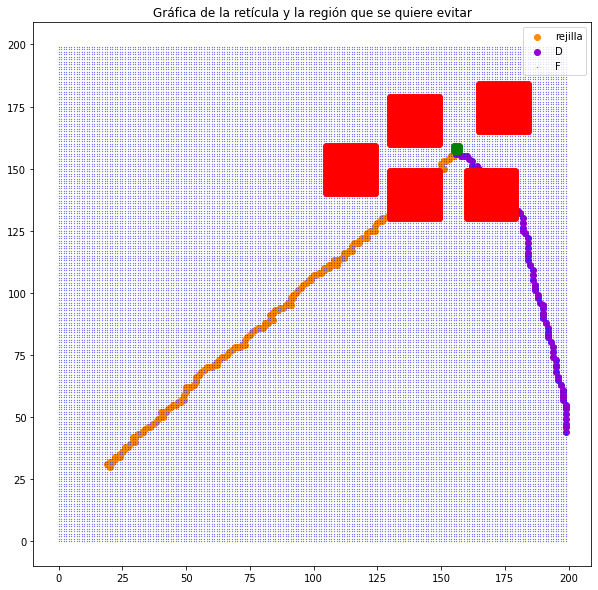

In [ ]:
#Primer punto inicial
graficar6k_LP=simulacion(d_estrella,6020)
fig, axx_LP = plt.subplots(figsize=(10,10))
x6k_LP=[i%(200-M)+M for i in graficar6k_LP]
y6k_LP=[i//(200-M)+M for i in graficar6k_LP]
#segundo punto inicial
graficar8k_LP=simulacion(d_estrella,8999)
x8k_LP=[i%(200-M)+M for i in graficar8k_LP]
y8k_LP=[i//(200-M)+M for i in graficar8k_LP]

axx_LP.scatter(x6k_LP,y6k_LP,c='darkorange')
axx_LP.scatter(x8k_LP,y8k_LP,c='darkviolet')
GraficarRetícula(axx_LP)

In [ ]:
dictSimulacion_LP={6020:[],8999:[]}
for simular in range(100):
  dictSimulacion_LP[6020].append(len(simulacion(d_estrella ,6020)))
  dictSimulacion_LP[8999].append(len(simulacion(d_estrella,8999)))

Varianza con punto de partida=(20,30) 9.300596755047495
Varianza con punto de partida=(199,44) 4.922143841864031


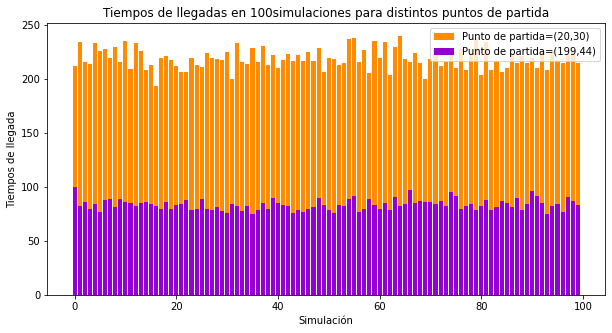

In [ ]:
fig, axSim_LP = plt.subplots(figsize=(10,5))
axSim_LP.bar(range(100),dictSimulacion_LP[6020],color='darkorange')
axSim_LP.bar(range(100),dictSimulacion_LP[8999],color='darkviolet')
axSim_LP.set_title('Tiempos de llegadas en 100simulaciones para distintos puntos de partida')
axSim_LP.set_xlabel('Simulación')
axSim_LP.set_ylabel('Tiempos de llegada')
print('Varianza con punto de partida=('+str(6020%(200-M)+M)+','+str(6020//(200-M)+M)+')', np.std(dictSimulacion_LP[6020]) )
print('Varianza con punto de partida=('+str(8999%(200-M)+M)+','+str(8999//(200-M)+M)+')', np.std(dictSimulacion_LP[8999]) )


axSim_LP.legend(['Punto de partida=('+str(6020%(200-M)+M)+','+str(6020//(200-M)+M)+')','Punto de partida=('+str(8999%(200-M)+M)+','+str(8999//(200-M)+M)+')'])

## Análisis de sensibilidad

Las trayectorias obtendias con policy iteration evitan mejor las zonas rojas y por lo tanto utilizaremos policy iteration para realizar el análisis de sensibilidad. Además, policy iteration se demora menos ejecutando. Aunque lo anterior demuestra que en general ambas reglas de decisión arrojan resultados bastante parecidos.

In [ ]:
medianas6=[]
medianas8=[]
ReglasDecision=[]
for lmbda in np.arange(0.85,0.99, step=0.01):
  #Implementamos el algoritmo
  try:
    d=pd.read_csv('/content/drive/MyDrive/OEstocastica/vNext_'+str(M)+'.csv', index_col='Unnamed: 0').values.reshape(-1,)
    #print('si lo leyó')
  except:
    d=np.random.choice(['u','d','l','r'], size=(200-M)**2, replace=True)
    print('pichis')
  dNext=np.zeros((200-M)**2,)
  cont=0
  parar=False
  while not parar and cont<100:
    P_d=P(d)
    r_d=rec_d(d)
    matriz=identity((200-M)**2)-lmbda*P_d
    v=bicg(matriz,r_d)[0]
    cont+=1
    columnas=[ Pr_u.dot(v), Pr_d.dot(v), Pr_l.dot(v), Pr_r.dot(v) ]
    vector=recompensasEstados.T + lmbda*np.array(columnas).T
    nuevo_d=np.argmax(vector,axis=1).tolist()
    dNext=np.array(list(map(acciones.get, nuevo_d)))
    if np.all(np.max(vector,axis=1)==vector[np.arange((200-M)**2),list(map(accionesInv.get, d.tolist()))]):
      print('AAAAAAAAAAAAAAAAAAAAAAAAAA')
      parar=True
    d=dNext
    
  #Simulamos 100 trayectorias paara los dos puntos iniciales
  #Y calculamos su mediana 
  dictSimulacion={6020:[],8999:[]}
  
  ReglasDecision.append(dNext)
  


  for simular in range(100):
    sim6=simulacion(dNext,6020)
    sim8=simulacion(dNext,8999)
    
    dictSimulacion[6020].append(len(sim6))
    dictSimulacion[8999].append(len(sim8))
  medianas6.append(np.median(dictSimulacion[6020]))
  medianas8.append(np.median(dictSimulacion[8999]))

1
3
1
1
2
2
2
0
1
0
1
2
1
0
1
0
2
0
1
1
1
3
3
3
0
0
2
0
1
1
2
3
0
2
2
2
1
1
1
1
3
2
3
1
1
3
1
1
2
0
0
1
3
0
0
0
2
2
1
0
1
1
0
1
0
1
1
1
0
0
2
2
0
1
0
1
3
0
2
3
2
1
0
2
0
1
1
0
1
1
1
1
0
1
1
0
1
1
2
0
2
2
0
0
3
1
2
1
1
0
1
1
2
1
1
0
2
0
3
1
1
0
1
0
1
1
3
2
0
2
1
2
1
0
0
0
1
1
1
1
1
0
1
0
0
0
1
1
1
1
1
0
0
1
0
0
0
1
1
2
1
1
0
0
0
1
1
3
2
2
1
0
0
0
1
2
1
3
1
1
3
1
1
2
3
1
0
1
0
1
1
0
1
1
1
0
0
0
1
1
0
1
1
1
0
0
0
1
1
1
2
1
2
2
2
0
2
1
0
1
1
1
2
2
1
1
2
2
1
0
0
1
1
1
0
1
0
0
1
1
1
1
3
0
1
2
1
1
1
1
0
0
0
1
1
2
0
1
1
0
1
1
0
1
2
1
1
0
3
1
1
1
0
3
1
0
0
3
0
1
2
1
0
1
2
1
1
1
0
0
2
0
0
0
1
1
1
0
2
1
1
0
0
1
1
0
1
0
1
1
0
3
1
3
1
2
1
1
3
1
0
3
2
0
2
0
1
3
0
1
1
1
2
2
1
2
0
0
0
1
1
1
1
1
2
0
1
1
1
1
2
1
0
0
1
1
3
1
3
0
1
0
1
1
2
1
1
1
2
1
2
0
1
0
0
2
1
3
0
0
2
2
1
2
0
1
2
3
0
1
1
0
1
1
3
1
2
2
0
2
0
2
1
0
1
0
2
1
1
0
1
1
2
1
1
1
0
0
1
0
1
0
3
0
1
0
0
0
3
1
2
1
1
1
1
1
0
2
0
2
0
1
0
1
0
0
1
2
3
2
1
1
1
3
2
1
2
1
1
0
0
0
0
2
2
0
1
1
1
1
2
0
0
0
3
1
1
1
1
2
0
2
1
0
1
0
0
1
1
1
1
0
1
0
0
1
2
0
0
1


### Comparación para distintos valores de $\lambda$

Ahora graficamos las medianas de los tiempos de llegada obtenidas de 100 simulaciones para cada punto de partida fijo y cada $\lambda$.

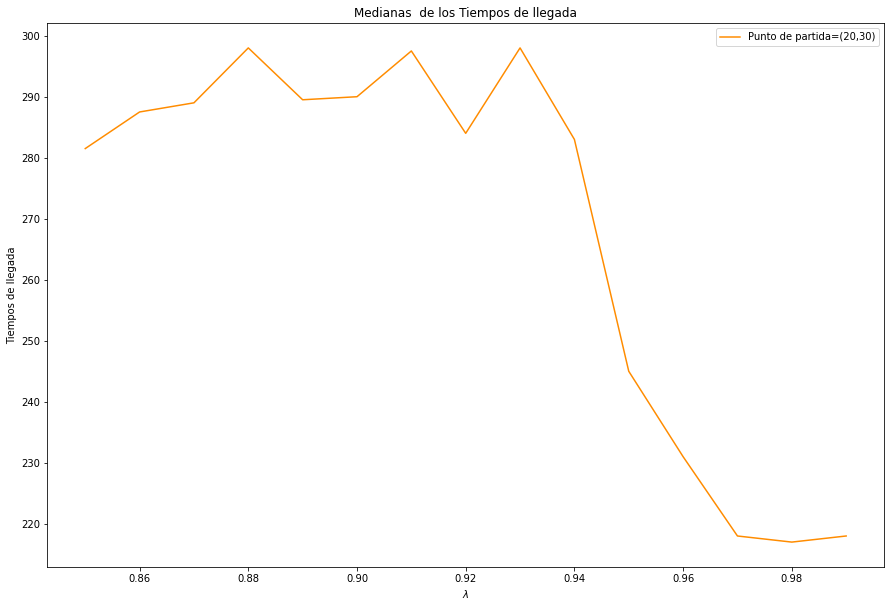

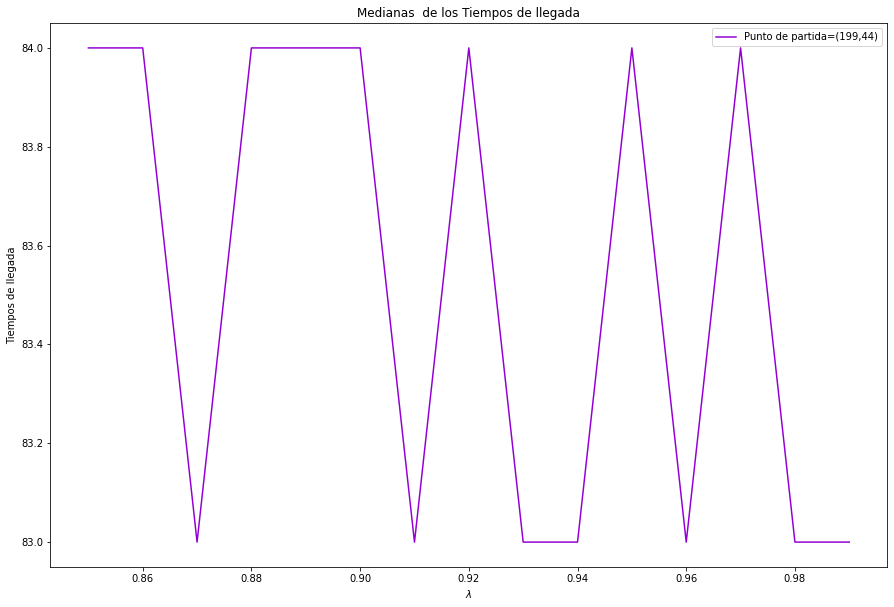

In [ ]:
fig, axSen = plt.subplots(figsize=(15,10))
fig, axSen1 = plt.subplots(figsize=(15,10))

axSen.plot(np.arange(0.85,0.99, step=0.01),medianas6,color='darkorange')
axSen1.plot(np.arange(0.85,0.99, step=0.01),medianas8,color='darkviolet')
axSen.set_title('Medianas  de los Tiempos de llegada')
axSen.set_xlabel(r'$\lambda$')
axSen.set_ylabel('Tiempos de llegada')

axSen1.set_title('Medianas  de los Tiempos de llegada')
axSen1.set_xlabel(r'$\lambda$')
axSen1.set_ylabel('Tiempos de llegada')
axSen.legend(['Punto de partida=('+str(6020%(200-M)+M)+','+str(6020//(200-M)+M)+')'])
axSen1.legend(['Punto de partida=('+str(8999%(200-M)+M)+','+str(8999//(200-M)+M)+')'])

En lo anterior se evidencia que conforme $\lambda \to 1$, la regla de decisión óptima resulta en menos pasos para alcanzar el objetivo.

Ahora veamos si evitan los obstáculos cuando $\lambda \to 1$

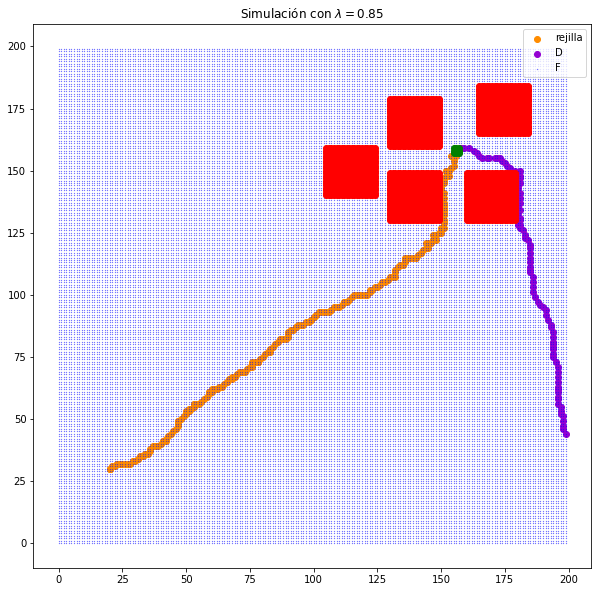

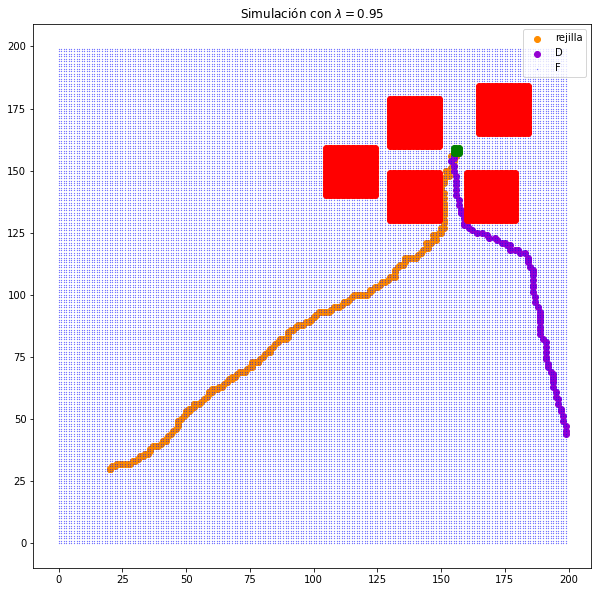

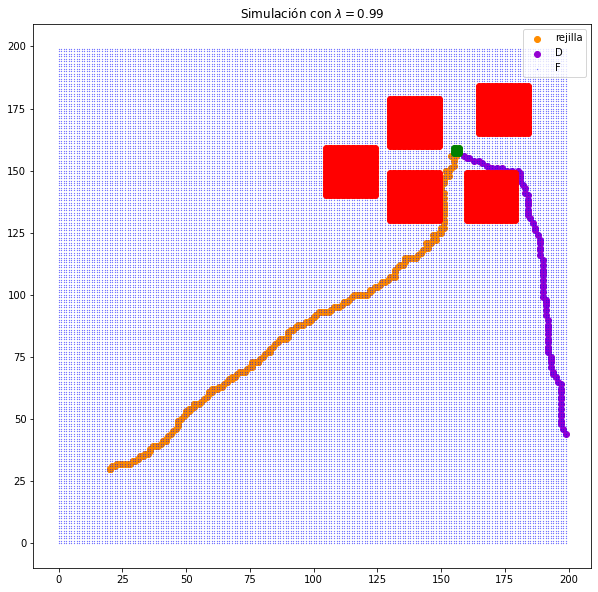

In [ ]:
for i in range(3):
  fig, axx_LP = plt.subplots(figsize=(10,10))

  #Primer punto inicial
  graficar6_ultimo=simulacion(ReglasDecision[5*i],6020)
  
  x6_ultimo=[i%(200-M)+M for i in graficar6k_LP]
  y6_ultimo=[i//(200-M)+M for i in graficar6k_LP]
  axx_LP.scatter(x6_ultimo,y6_ultimo,c='darkorange')
  #segundo punto inicial
  graficar8k_LP=simulacion(ReglasDecision[5*i],8999)
  x8k_LP=[i%(200-M)+M for i in graficar8k_LP]
  y8k_LP=[i//(200-M)+M for i in graficar8k_LP]
  axx_LP.scatter(x8k_LP,y8k_LP,c='darkviolet')
  GraficarRetícula(axx_LP, imprimir=False)
  
  axx_LP.set_title('Simulación con '+r'$\lambda=$'+str({0:0.85,1:0.95,2:0.99}[i]))

Entonces cuando $\lambda \to 1$ la política óptima correspondiente también evita los obstáculos